In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [25]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

#inspect not part of assignment

#not in assignment
from sqlalchemy import text

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
engine
#Base.metadata.create_all(engine)

Engine(sqlite:///Resources/hawaii.sqlite)

In [16]:
conn = engine.connect()
measurement_data = pd.read_sql("SELECT * FROM measurement", conn)
measurement_data.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [17]:
station_data = pd.read_sql("SELECT * FROM station", conn)
station_data.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [18]:
##Not in assignment
# Merge the DataFames on the "CityState" column. 
combined_data = pd.merge(measurement_data, station_data, on="station", how="inner")

# Display the merged DataFrame.
combined_data.head()


,id_x,station,date,prcp,tobs,id_y,name,latitude,longitude,elevation
0,1,USC00519397,2010-01-01,0.08,65.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00519397,2010-01-02,0.00,63.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
2,3,USC00519397,2010-01-03,0.00,74.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
3,4,USC00519397,2010-01-04,0.00,76.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
4,5,USC00519397,2010-01-06,NaN,73.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0


In [8]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [9]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [10]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [11]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)


# Exploratory Precipitation Analysis

In [35]:
# Find the most recent date in the data set.
most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent


('2017-08-23',)

In [228]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
#print("Query Date: ", query_date)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.prcp, 
                        Measurement.date).\
                  filter(Measurement.date > query_date).all()
prcp_df = pd.DataFrame(results)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = prcp_df.rename(columns={'prcp': 'Precipitation', 'date': 'Observation Date'})


# Sort the dataframe by date
prcp_df_sorted = prcp_df.sort_values('Observation Date', ascending=True).reset_index(drop=True)
prcp_df_final = prcp_df_sorted[['Precipitation','Observation Date']]
prcp_df_final = prcp_df_final.set_index('Observation Date')


prcp_df_final


,Precipitation
Observation Date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


ValueError: 'locs' must be 1D with shape (N,), but your input has shape ()

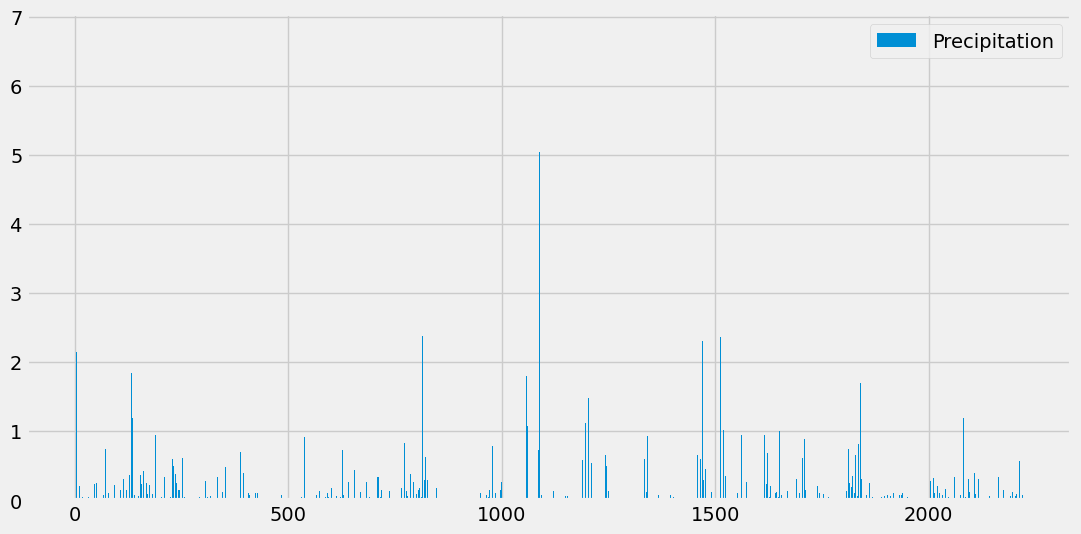

In [231]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_plot = prcp_df_final.plot(kind="bar", figsize=(12,6), xlabel="Date", ylabel="Inches", xticks=5)
#facecolor="blue", width=.75, xticks=([1, 2, 3, 4, 5])                             

plt.show()
plt.tight_layout()
#plt.xticks = (['2016-08-24', '2016-11-23', '2017-2-23', '2017-5-23', '2017-08-23'])

In [96]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = pd.DataFrame(prcp_df_sorted["Precipitation"].describe())
summary_stats

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [153]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.station)).all()

[(9,)]

In [160]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [196]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs),  func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()    




[('USC00519281', 54.0, 85.0, 71.66378066378067)]

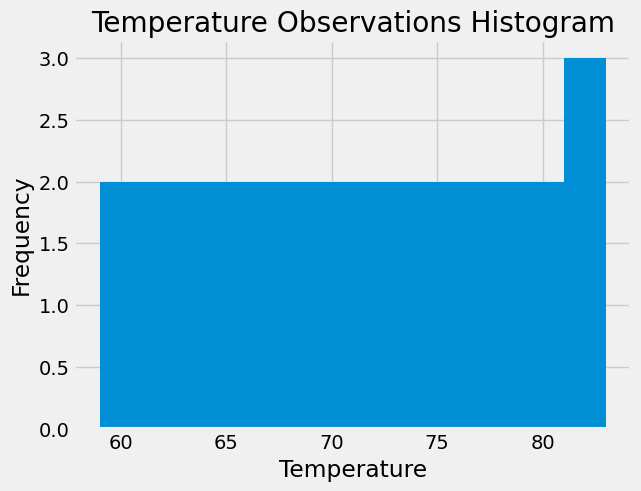

In [244]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperatures = session.query(Measurement.tobs, func.count(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date > query_date).\
    group_by(Measurement.tobs).all()

temperatures



temperatures_df = pd.DataFrame(temperatures, columns=[['Temperature', 'Frequency']])




# Plotting a histogram
plt.hist(temperatures_df['Temperature'], bins=12)

plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Observations Histogram')

# Display the plot
plt.show()

# Close Session

In [245]:
# Close Session
session.close()